### Correlation Mapping in Python


The Pearson correlation coefficient measures the linear relationship between two datasets. The calculation of the p-value relies on the assumption that each dataset is normally distributed. 

Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html for more info. Or [Correlation Visuals (click me).](https://files.realpython.com/media/py-corr-1.d13ed60a9b91.png)


In [1]:
#we will start by adding some libraries & reading in precip. data that we already have on file

from matplotlib import pyplot as plt
import numpy as np
import netCDF4

file1='/projects/jiko1138/ATOC_3030/Nov_04/precip.mon.mean.nc'     
nc = netCDF4.Dataset(file1)      

In [2]:
#now I'm prepping data

precip = nc.variables['precip'][:,:,:]        # a stack of precipitation maps that is nmonths high!
print('precip shape:',precip.shape) 

region1 = nc.variables['precip'][:,30,50]     # Rainfall rates at one geographic location (Borneo) for nmonths
print('region1 shape:',region1.shape)



lats = nc.variables['lat'][:]             #reading in lats to numpy array
lons = nc.variables['lon'][:]             #reading in lons to numpy array
mnth = nc.variables['time'][:]            #reading in times to numpy array called mnth

#this code changes the netcdf time to a date time that is more plot friendly.

time = nc.variables['time'] # temperature variable as an object. This call is needed so the time units are read in

dtime = netCDF4.num2date(mnth[:],time.units)

print(dtime[0])  #what is the first month?
print(dtime[12]) #check to see if this goes up a year
print(dtime[-1]) #what is last month?

precip shape: (493, 72, 144)
region1 shape: (493,)
1979-01-01 00:00:00
1980-01-01 00:00:00
2020-01-01 00:00:00


In [3]:
from scipy import stats          #import stats library


Now we need to get a correlation coefficient for region1 time series vs. every times series at each lat and lon. The goal is to get a map of correlation coefficients. 

The science question is "How well do other regions' monthly precip correlate with region1's monthly precip?"

Although this may be a relatively dull science question, we at least know that we will get a value of R = 1 for region1 on the map and this can provide a check that we did it correctly

In [4]:
dum=np.zeros((72,144))    #making a blank array of the shape I need (nlats, nlons). Correlations will fill this ultimately
dum2=np.zeros((72,144))   #making 2nd blank array to hold p values
print(dum.shape)


nlats = np.arange(72)                   #create a variable of number of lats that we will loop through
nlons = np.arange(144)                  #create a variable of number of lons that we will loop through

#doing a double loop below to step through all lats and lons needed. Note that the indentations are specific in Python!!

for i in nlons:
    for j in nlats:
        corrs, pvalue =stats.pearsonr(region1[:], precip[:,j,i])  #create corr. coeffs. between region1 and others
        #print(temp)
        
        dum[j,i]=corrs                                            #fills my preformed array with R values!
        
        #print(dum[j,i])
        
        dum2[j,i]=pvalue                                          #p values may come in handy to mask out less confident values
                                              
print(dum.shape)
print(dum2.shape)

(72, 144)
(72, 144)
(72, 144)


In [5]:
# !apt-get install libproj-dev proj-data proj-bin
# !apt-get install libgeos-dev
# !pip install cython
# !pip install cartopy
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

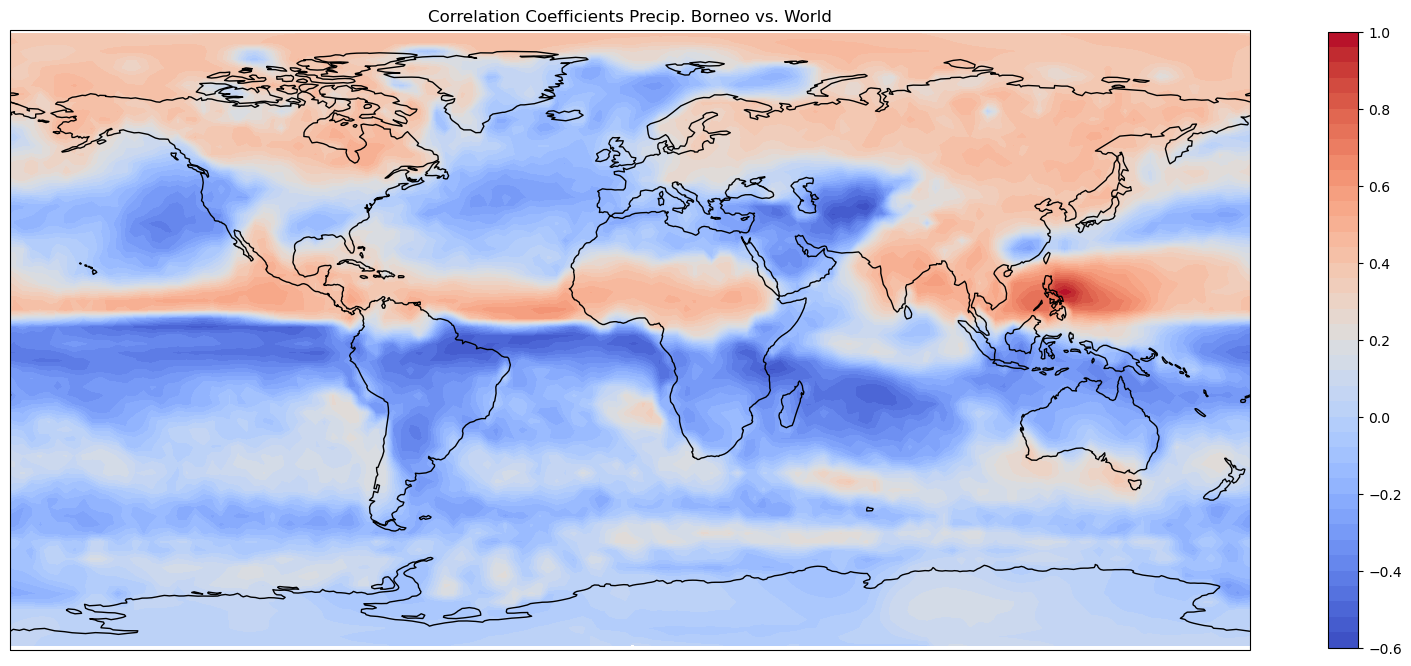

In [6]:
#using past script to create a map

from cartopy.util import add_cyclic_point

tdum, lons_w = add_cyclic_point(dum, coord=lons)  #this chunk wraps the data so no blank vertical line on map

plt.figure(figsize=(20,10))                     #making figure size

ax = plt.axes(projection=ccrs.PlateCarree())    #setting projection (Cartopy is used here)

plt.contourf(lons_w, lats, tdum, 40,
             transform=ccrs.PlateCarree(), cmap='coolwarm')   #the 40 number specifies # of data intervals
                                                              #cmap sets colormap 

plt.title('Correlation Coefficients Precip. Borneo vs. World')
ax.set_global()
ax.coastlines()
cbar=plt.colorbar(orientation='vertical',shrink=0.8)

plt.show()

### The bright red spot is near Borneo and is where region1 timeseries is from. Of course, the correlation is perfect there since it is the monthly rainfall rates vs. monthly rainfall rates for the same region

### Otherwise, you can see the continuity across the ITCZ and some interesting negative correlation with the descending branch of Hadley Cell to S. More lift in one region leads to more descent in another.

**Masking arrays**

We wish to mask the correlation array based on the p-values. Specifically, for 90% confidence we want p less than or equal to .1

All grid points where p > .1 should be masked out 

In [7]:
import numpy.ma as ma  #importing some masking functions and called that package 'ma'
  
# Below I will mask the correlation array (dum) by using the p value array (dum2)
# where the condition for masking is that dum2 is greater than 0.1 
# Our goal is to only display correlation values where p is less than or equal to 0.1 (90% confidence)
# If the p value > .1 at some grid point, the correlation value at that grid point is masked

masked_corrs = ma.masked_where(dum2 > .1, dum)
masked_corrs.shape
masked_corrs

masked_array(
  data=[[0.4091536287899393, 0.415768687775849, 0.4140487177051426, ...,
         0.4205920701779165, 0.4208552199610226, 0.4104604758616301],
        [0.3805079010945146, 0.36073596627378285, 0.3569257900499343,
         ..., 0.37952831959616473, 0.3736395070859074,
         0.38465564686690906],
        [0.2836489062836471, 0.2677863771480395, 0.2648161259380262, ...,
         0.24468332139831794, 0.2511559302608819, 0.2761363825259543],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

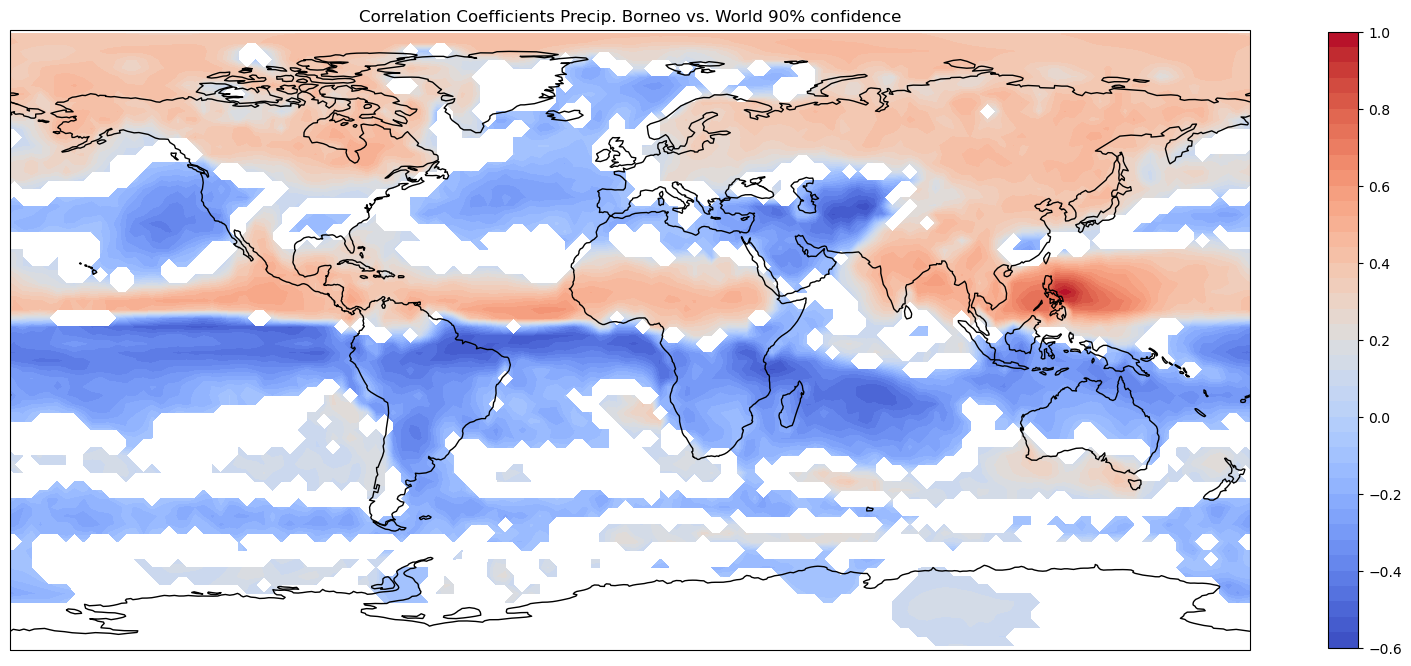

In [8]:
from cartopy.util import add_cyclic_point

tdum, lons_w = add_cyclic_point(masked_corrs, coord=lons)  #this chunk wraps the data so no blank vertical line on map

plt.figure(figsize=(20,10))                     #making figure size

ax = plt.axes(projection=ccrs.PlateCarree())    #setting projection (Cartopy is used here)

plt.contourf(lons_w, lats, tdum, 40,
             transform=ccrs.PlateCarree(), cmap='coolwarm')   #the 40 number specifies # of data intervals
                                                              #cmap sets colormap 

plt.title('Correlation Coefficients Precip. Borneo vs. World 90% confidence')
ax.set_global()
ax.coastlines()
cbar=plt.colorbar(orientation='vertical',shrink=0.8)

plt.show()

Perhaps not as pretty as the first map but certainly more scientifically rigorous!

Much more in depth correlation tutorial here: https://realpython.com/numpy-scipy-pandas-correlation-python/


Next we will import some El Nino Index Data. Specifically the MEI index that you will use in HW3 with the Reanalyzer

In [9]:
from numpy import genfromtxt
data = genfromtxt('/content/MEI_MONTHLY_1979-2020.csv',delimiter=',')

data.shape

#print(data)

dum_mei = data.flatten()    #flattening the 2D Excel sheet (year vs. months) into 1D to match precip file format

dum_mei.shape

dum_mei[0]=0.47             #for some reason the first data value wasn't read in correctly. Unclear as to why..

dum_mei.shape

mei=dum_mei[0:493]          #trimming file for 1/1979 to 1/2020     

mei.shape

FileNotFoundError: /content/MEI_MONTHLY_1979-2020.csv not found.

I have already copied and pasted code you will need. You just need to change some variable names around and do some light weight coding in each coding box below.

I would like a correlation map of monthly MEI vs. precip with values at P > .05 (95% confidence) masked out

In [ ]:
dum=np.zeros((72,144))    #making a blank array of the shape I need (nlats, nlons). Correlations will fill this ultimately
dum2=np.zeros((72,144))   #making 2nd blank array to hold p values
print(dum.shape)


nlats = np.arange(72)                   #create a variable of number of lats that we will loop through
nlons = np.arange(144)                  #create a variable of number of lons that we will loop through

#doing a double loop below to step through all lats and lons needed. Note that the indentations are specific in Python!!

for i in nlons:
    for j in nlats:
        corrs, pvalue =stats.pearsonr(region1[:], precip[:,j,i])  #create corr. coeffs. between region1 and others
        #print(temp)
        
        dum[j,i]=corrs                                            #fills my preformed array with R values!
        
        #print(dum[j,i])
        
        dum2[j,i]=pvalue                                          #p values may come in handy to mask out less confident values
                                              
print(dum.shape)
print(dum2.shape)

In [ ]:
from cartopy.util import add_cyclic_point

tdum, lons_w = add_cyclic_point(dum, coord=lons)  #this chunk wraps the data so no blank vertical line on map

plt.figure(figsize=(20,10))                     #making figure size

ax = plt.axes(projection=ccrs.PlateCarree())    #setting projection (Cartopy is used here)

plt.contourf(lons_w, lats, tdum, 40,
             transform=ccrs.PlateCarree(), cmap='coolwarm')   #the 40 number specifies # of data intervals
                                                              #cmap sets colormap 

plt.title('Correlation Coefficients ?????????????????')
ax.set_global()
ax.coastlines()
cbar=plt.colorbar(orientation='vertical',shrink=0.8)

plt.show()

In [ ]:
import numpy.ma as ma  #importing some masking functions and called that package 'ma'
  
# Below I will mask the correlation array (dum) by using the p value array (dum2)
# where the condition for masking is that dum2 is greater than 0.1 
# Our goal is to only display correlation values where p is less than or equal to 0.1 (90% confidence)
# If the p value > .1 at some grid point, the correlation value at that grid point is masked

masked_corrs = ma.masked_where(dum2 > .1, dum)
masked_corrs.shape
masked_corrs

#You'll see on the output that there is now a mask of Boolean operators (True/False)
#within the masked_corrs variables (the correlation data is also in there)

In [ ]:
from cartopy.util import add_cyclic_point

tdum, lons_w = add_cyclic_point(masked_corrs, coord=lons)  #this chunk wraps the data so no blank vertical line on map

plt.figure(figsize=(20,10))                     #making figure size

ax = plt.axes(projection=ccrs.PlateCarree())    #setting projection (Cartopy is used here)

plt.contourf(lons_w, lats, tdum, 40,
             transform=ccrs.PlateCarree(), cmap='coolwarm')   #the 40 number specifies # of data intervals
                                                              #cmap sets colormap 

plt.title('Correlation Coefficients ???????????????????????')
ax.set_global()
ax.coastlines()
cbar=plt.colorbar(orientation='vertical',shrink=0.8)

plt.show()